## Task 2
Author: Danis Alukaev <br>
Email: d.alukaev@innopolis.university <br>
Group: B19-DS-01

### 0 Prerequisites

In [1]:
import copy
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from geopy.distance import distance
from matplotlib.animation import FuncAnimation

In [2]:
def load_metadata_top30(path):
    data = pd.read_csv(path)
    top30 = data.sort_values("population", ascending=False).iloc[:30]
    return top30

top30 = load_metadata_top30("city.csv")

In [3]:
def load_outline_russia(path):
    with open(path) as f:
        data = json.load(f)[0]
    geojson = data["geojson"]
    outline = geojson["coordinates"]
    return outline
    
outline = load_outline_russia("russia.json")

### 1 Simulated Annealing

In [5]:
class TravelingSalesmanPath:

    def __init__(self, cities_metadata):
        self.cities_metadata = cities_metadata
        self.n_cities = len(cities_metadata)
        self.city_ids = np.arange(0, self.n_cities, 1)
    
    def propose_new(self):
        id1, id2 = np.random.randint(0, self.n_cities, size=2)
        city_ids_ = self.city_ids.copy()
        city_ids_[id1], city_ids_[id2] = city_ids_[id2], city_ids_[id1]
        path_ = self.copy()
        path_.set_city_ids(city_ids_)
        return path_

    def cumulative_distance(self):
        running_sum = 0.
        geo_labels = ["geo_lat", "geo_lon"]
        for city_id in range(self.city_ids.shape[0]):
            next_city_id = (city_id + 1) % self.n_cities

            city_idx = self.city_ids[city_id]
            next_city_idx = self.city_ids[next_city_id]

            city = self.cities_metadata.iloc[city_idx]
            next_city = self.cities_metadata.iloc[next_city_idx]
            dist_ = distance(city[geo_labels], next_city[geo_labels]).km
            running_sum += dist_
        return running_sum

    def get_city_ids(self):
        return self.city_ids
    
    def set_city_ids(self, city_ids):
        self.city_ids = city_ids
    
    def copy(self):
        return copy.deepcopy(self)

In [6]:
class SimulatedAnnealing:

    def __init__(
            self, 
            cities_metadata, 
            n_iterations=1000,
            temperature=1000., 
            rate=0.99,
            min_temperature=1.,
            verbose=False, 
            log_every_n_iter=100,
    ):
        self.cities_metadata = cities_metadata
        self.n_iterations = n_iterations
        self.temperature = temperature
        self.rate = rate
        self.min_temperature = min_temperature
        self.verbose = verbose
        self.log_every_n_iter = log_every_n_iter

        self.path = TravelingSalesmanPath(cities_metadata)
        self.history = {
            "dist": list(),
            "path": list(),
        }
    
    def run(self):
        for iteration in range(self.n_iterations):
            self.path = self._sample()
            self._anneal()

            current_distance = self.path.cumulative_distance()
            self.history["dist"].append(current_distance)
            self.history["path"].append(self.path)

            if not self.verbose:
                if iteration % self.log_every_n_iter == 0:
                    print(f"Iteration {iteration}: dist={current_distance:.2f} t={self.temperature:2f}")

    def _sample(self):
        proposal = self.path.propose_new()
        acceptance_ratio = self.compute_acceptance_ratio(self.path, proposal)
        u = np.random.uniform()
        if u <= acceptance_ratio:
            return proposal
        return self.path

    def _anneal(self):
        self.temperature = max(self.min_temperature, self.rate * self.temperature)
        
    def compute_acceptance_ratio(self, current, proposal):
        # TODO close to zero
        alpha = np.exp((-proposal.cumulative_distance() + current.cumulative_distance()) / self.temperature, dtype=np.float128)
        return alpha

In [7]:
simulated_annealing = SimulatedAnnealing(top30)

In [8]:
simulated_annealing.run()

Iteration 0: dist=65890.89 t=990.000000
Iteration 100: dist=36945.56 t=362.372018
Iteration 200: dist=30098.76 t=132.639878
Iteration 300: dist=29013.94 t=48.550485
Iteration 400: dist=28873.92 t=17.771048
Iteration 500: dist=27429.75 t=6.504778
Iteration 600: dist=25633.13 t=2.380959
Iteration 700: dist=24699.71 t=1.000000
Iteration 800: dist=23391.58 t=1.000000
Iteration 900: dist=23234.90 t=1.000000


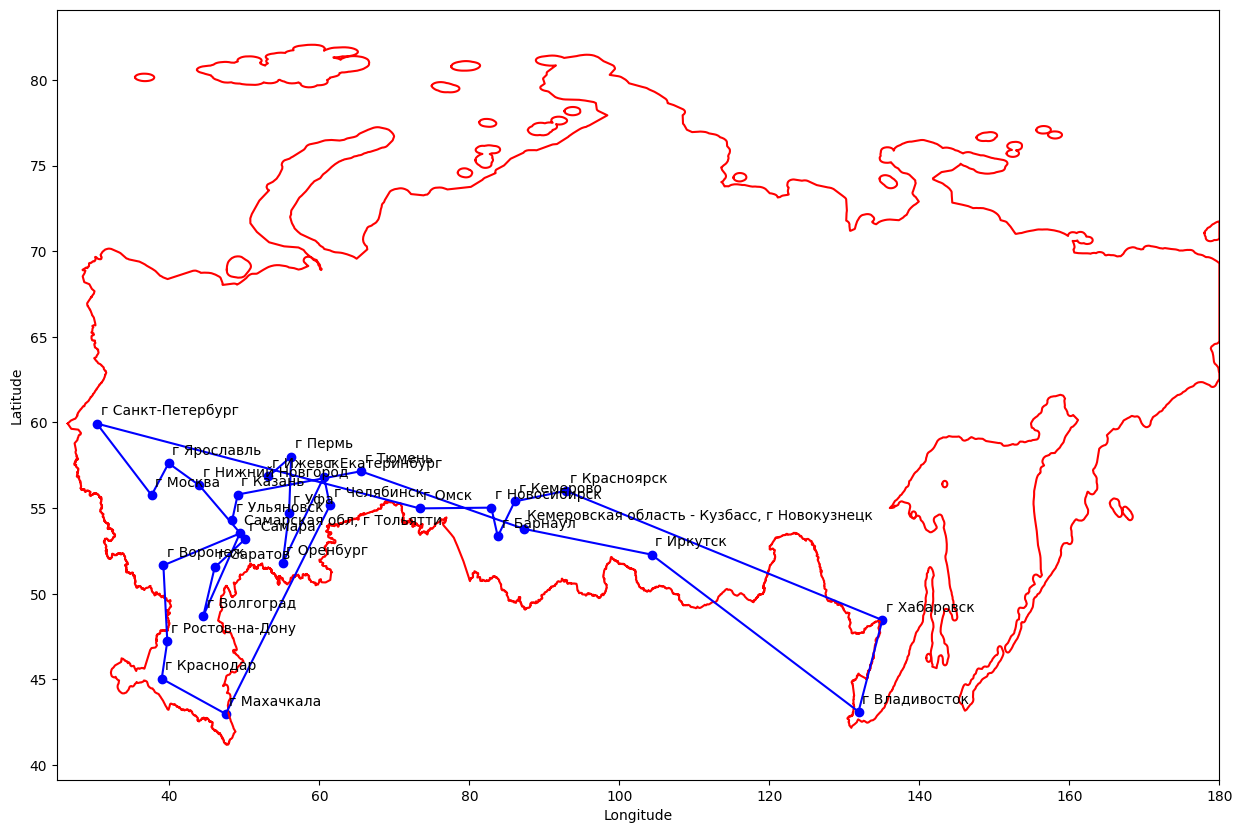

In [22]:
class Plotter:

    def __init__(self, history, outline):
        self.history = history["path"]
        self.outline = outline
        self.fig = plt.figure(figsize=(15, 10))
    
    def narrow_history(self, every_n=100):
        history_ = [p for idx, p in enumerate(self.history) if idx % every_n == 0]
        return history_
    
    def plot(self, path):
        plt.clf()

        for polygon in self.outline:
            xs = [c[0] for c in polygon[0]]
            ys = [c[1] for c in polygon[0]]
            plt.plot(xs, ys, c='r')

        city_ids = path.get_city_ids()
        cities = path.cities_metadata[['geo_lat', 'geo_lon', 'address']].iloc[city_ids]
        xs, ys = cities.geo_lon, cities.geo_lat

        plt.scatter(xs, ys, c='b')
        plt.plot(xs, ys, c='b')

        for city_id in range(len(cities)):
            plt.annotate(cities.iloc[city_id].address, (cities.iloc[city_id].geo_lon + 0.5, cities.iloc[city_id].geo_lat + 0.5))
        
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.xlim([25, 180])

plotter = Plotter(simulated_annealing.history, outline)
gif = FuncAnimation(plotter.fig, plotter.plot, plotter.narrow_history(every_n=10), interval=200)   
gif.save('simulation.gif', fps=10)